## Task 1: analyze the bias

- calculate the mean pixel value of the brain tissue (within a ROI) for each image.

## Task 2: metric calculation

- calculate MAE, RMSE, SSIM and LPIPS.

## Task 3: analyze the effect of the number of inference averaged

- calculate the MAE, RMSE, SSIM and LPIPS with 2,4,6,8,10,12,14,16,18,20 inferences averaged

---

### Docker environment
Please use `docker/docker_pytorch`, it will build a tensorflow docker


In [8]:
import sys
sys.path.append('/workspace/Documents')
import os
import torch
import lpips
import numpy as np 
import nibabel as nb
import pandas as pd
from scipy.ndimage import binary_erosion, generate_binary_structure
import CTDenoising_Diffusion_N2N.functions_collection as ff
import CTDenoising_Diffusion_N2N.Build_lists.Build_list as Build_list
import CTDenoising_Diffusion_N2N.Data_processing as Data_processing

main_path = '/mnt/camca_NAS/denoising/'

### define a patient list

In [2]:
build_sheet =  Build_list.Build(os.path.join(main_path,'Patient_lists/fixedCT_static_simulation_train_test_gaussian_NAS.xlsx'))
_,patient_id_list,patient_subid_list,random_num_list, condition_list, x0_list = build_sheet.__build__(batch_list = [5]) 
n = ff.get_X_numbers_in_interval(total_number = patient_id_list.shape[0],start_number = 0,end_number = 1, interval = 2) # each case has two simulations, we do on the first one as example

### Task 1 and 2
output:
- ```mean_measurements.xlsx``` for task 1
- ```quantitative_results.xlsx``` for task 2

In [ ]:
results = []; results_mean = []
for i in range(0,n.shape[0]):
    patient_id = patient_id_list[n[i]]
    patient_subid = patient_subid_list[n[i]]
    random_n = random_num_list[n[i]]
    print(patient_id, patient_subid, random_n)

    # reference image
    gt_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta0/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch61_1/gt_img.nii.gz')
    gt_img = nb.load(gt_file).get_fdata()
    gt_img_brain = Data_processing.cutoff_intensity(gt_img, cutoff_low=-100, cutoff_high=100)

    # noisy image
    condition_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta0/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch61_1/condition_img.nii.gz')
    condition_img = nb.load(condition_file).get_fdata()
    condition_img_brain = Data_processing.cutoff_intensity(condition_img, cutoff_low=-100, cutoff_high=100)

    # noise2noise
    noise2noise_file = os.path.join(main_path, 'models/noise2noise/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch78/pred_img.nii.gz')
    noise2noise_img = nb.load(noise2noise_file).get_fdata() 
    noise2noise_img_brain = Data_processing.cutoff_intensity(noise2noise_img, cutoff_low=-100, cutoff_high=100)

    # supervised method
    supervised_file = os.path.join(main_path, 'models/supervised_possion/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch58_1/pred_img.nii.gz')
    supervised_img = nb.load(supervised_file).get_fdata() 
    supervised_img_brain = Data_processing.cutoff_intensity(supervised_img, cutoff_low=-100, cutoff_high=100)

    # supervised_avg_file = os.path.join(main_path, 'models/supervised_DDPM_possion_2D/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch50final/pred_img.nii.gz')
    # supervised_avg_img = nb.load(supervised_avg_file).get_fdata() 
    # supervised_avg_img_brain = Data_processing.cutoff_intensity(supervised_avg_img, cutoff_low=-100, cutoff_high=100)

    # our method (unsupervised), beta = 0, 1 inference
    unsupervised_beta0_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta0/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch61_1/pred_img.nii.gz')
    unsupervised_beta0_img = nb.load(unsupervised_beta0_file).get_fdata()
    unsupervised_beta0_img_brain = Data_processing.cutoff_intensity(unsupervised_beta0_img, cutoff_low=-100, cutoff_high=100)

    # our method (unsupervised), beta = 0, 10 inference
    unsupervised_beta0_avg10_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta0/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch61avg/pred_img_scans10.nii.gz')
    unsupervised_beta0_avg10_img = nb.load(unsupervised_beta0_avg10_file).get_fdata()
    unsupervised_beta0_avg10_img_brain = Data_processing.cutoff_intensity(unsupervised_beta0_avg10_img, cutoff_low=-100, cutoff_high=100)

    # our method (unsupervised), beta = 0, 20 inference
    unsupervised_beta0_avg20_file = os.path.join(main_path, 'modelss/unsupervised_gaussian_current_beta0/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch61avg/pred_img_scans20.nii.gz')
    unsupervised_beta0_avg20_img = nb.load(unsupervised_beta0_avg20_file).get_fdata()
    unsupervised_beta0_avg20_img_brain = Data_processing.cutoff_intensity(unsupervised_beta0_avg20_img, cutoff_low=-100, cutoff_high=100)

    # our method (unsupervised), beta = 10, 1 inference
    unsupervised_beta10_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta10/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch65_1/pred_img.nii.gz')
    unsupervised_beta10_img = nb.load(unsupervised_beta10_file).get_fdata()
    unsupervised_beta10_img_brain = Data_processing.cutoff_intensity(unsupervised_beta10_img, cutoff_low=-100, cutoff_high=100)

    # our method (unsupervised), beta = 10, 10 inference
    unsupervised_beta10_avg10_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta10/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch65avg/pred_img_scans10.nii.gz')
    unsupervised_beta10_avg10_img = nb.load(unsupervised_beta10_avg10_file).get_fdata()
    unsupervised_beta10_avg10_img_brain = Data_processing.cutoff_intensity(unsupervised_beta10_avg10_img, cutoff_low=-100, cutoff_high=100)

    # our method (unsupervised), beta = 10, 20 inference
    unsupervised_beta10_avg20_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta10/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch65avg/pred_img_scans20.nii.gz')
    unsupervised_beta10_avg20_img = nb.load(unsupervised_beta10_avg20_file).get_fdata()
    unsupervised_beta10_avg20_img_brain = Data_processing.cutoff_intensity(unsupervised_beta10_avg20_img, cutoff_low=-100, cutoff_high=100)

    # our method (unsupervised), beta = 20, 1 inference
    unsupervised_beta20_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta20/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch58_1/pred_img.nii.gz')
    unsupervised_beta20_img = nb.load(unsupervised_beta20_file).get_fdata()
    unsupervised_beta20_img_brain = Data_processing.cutoff_intensity(unsupervised_beta20_img, cutoff_low=-100, cutoff_high=100)

    #### TASK 1: compare the mean value in brain region (crop a ROI in the center)
    x,y = 256,256
    mean_gt = np.mean(np.clip(gt_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_condition = np.mean(np.clip(condition_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_noise2noise = np.mean(np.clip(noise2noise_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_supervised= np.mean(np.clip(supervised_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_unsupervised_beta0 = np.mean(np.clip(unsupervised_beta0_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_unsupervised_beta0_avg10 = np.mean(np.clip(unsupervised_beta0_avg10_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_unsupervised_beta0_avg20 = np.mean(np.clip(unsupervised_beta0_avg20_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_unsupervised_beta10 = np.mean(np.clip(unsupervised_beta10_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_unsupervised_beta10_avg10 = np.mean(np.clip(unsupervised_beta10_avg10_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_unsupervised_beta10_avg20 = np.mean(np.clip(unsupervised_beta10_avg20_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))
    mean_unsupervised_beta20 = np.mean(np.clip(unsupervised_beta20_img_brain[x-50: x+50, y-50: y+50, 20:40],0,100))

    results_mean.append([patient_id, patient_subid, random_n,
    mean_gt, mean_condition, mean_noise2noise, mean_supervised,
    mean_unsupervised_beta0, mean_unsupervised_beta0_avg10, mean_unsupervised_beta0_avg20,
    mean_unsupervised_beta10, mean_unsupervised_beta10_avg10, mean_unsupervised_beta10_avg20,
    mean_unsupervised_beta20])
    df_mean = pd.DataFrame(results_mean, columns = ['patient_id', 'patient_subid', 'random_n',
    'mean_gt', 'mean_condition', 'mean_noise2noise', 'mean_supervised',
    'mean_unsupervised_beta0', 'mean_unsupervised_beta0_avg10', 'mean_unsupervised_beta0_avg20',
    'mean_unsupervised_beta10', 'mean_unsupervised_beta10_avg10', 'mean_unsupervised_beta10_avg20',
    'mean_unsupervised_beta20'])
    file_name = 'mean_measurements.xlsx'
    df_mean.to_excel(os.path.join(main_path, 'models', file_name), index = False)

    
    #### TASK2: compare brain region metrics 
    # define eroded mask
    mask = np.zeros(gt_img_brain.shape, dtype=bool)
    mask[(gt_img_brain>0) & (gt_img_brain < 100)] = 1
    structure = np.ones((6,6))
    mask_eroded = np.zeros_like(mask, dtype=bool)
    for i in range(mask.shape[2]):
        mask_eroded[:, :, i] = binary_erosion(mask[:, :, i], structure=structure, iterations=1)

    mae_motion, _, rmse_motion, _, ssim_motion,_ = ff.compare(condition_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
    mae_n2n, _, rmse_n2n, _, ssim_n2n, _ = ff.compare(noise2noise_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
    mae_supervised, _, rmse_supervised, _, ssim_supervised,_= ff.compare(supervised_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)

    mae_unsupervised_beta0, _, rmse_unsupervised_beta0, _, ssim_unsupervised_beta0,_ = ff.compare(unsupervised_beta0_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
    mae_unsupervised_beta0_avg10, _, rmse_unsupervised_beta0_avg10, _, ssim_unsupervised_beta0_avg10,_ = ff.compare(unsupervised_beta0_avg10_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
    mae_unsupervised_beta0_avg20, _, rmse_unsupervised_beta0_avg20, _, ssim_unsupervised_beta0_avg20,_ = ff.compare(unsupervised_beta0_avg20_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
    mae_unsupervised_beta10, _, rmse_unsupervised_beta10, _, ssim_unsupervised_beta10,_ = ff.compare(unsupervised_beta10_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
    mae_unsupervised_beta10_avg10, _, rmse_unsupervised_beta10_avg10, _, ssim_unsupervised_beta10_avg10,_ = ff.compare(unsupervised_beta10_avg10_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
    mae_unsupervised_beta10_avg20, _, rmse_unsupervised_beta10_avg20, _, ssim_unsupervised_beta10_avg20,_ = ff.compare(unsupervised_beta10_avg20_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
    mae_unsupervised_beta20, _, rmse_unsupervised_beta20, _, ssim_unsupervised_beta20,_ = ff.compare(unsupervised_beta20_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)


    print('motion metrics: ', mae_motion, rmse_motion, ssim_motion)
    print('n2n metrics: ', mae_n2n, rmse_n2n, ssim_n2n)
    print('supervised metrics: ', mae_supervised, rmse_supervised, ssim_supervised)
    print('unsupervised beta0 metrics: ', mae_unsupervised_beta0, rmse_unsupervised_beta0, ssim_unsupervised_beta0)
    print('unsupervised beta0 avg10 metrics: ', mae_unsupervised_beta0_avg10, rmse_unsupervised_beta0_avg10, ssim_unsupervised_beta0_avg10)
    print('unsupervised beta0 avg20 metrics: ', mae_unsupervised_beta0_avg20, rmse_unsupervised_beta0_avg20, ssim_unsupervised_beta0_avg20)
    print('unsupervised beta10 metrics: ', mae_unsupervised_beta10, rmse_unsupervised_beta10, ssim_unsupervised_beta10)
    print('unsupervised beta10 avg10 metrics: ', mae_unsupervised_beta10_avg10, rmse_unsupervised_beta10_avg10, ssim_unsupervised_beta10_avg10)
    print('unsupervised beta10 avg20 metrics: ', mae_unsupervised_beta10_avg20, rmse_unsupervised_beta10_avg20, ssim_unsupervised_beta10_avg20)
    print('unsupervised beta20 metrics: ', mae_unsupervised_beta20, rmse_unsupervised_beta20, ssim_unsupervised_beta20)

    ##### TASK2b: calculate lpips in brain
    lpips_motion = ff.compute_lpips_3d(condition_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)
    lpips_n2n = ff.compute_lpips_3d(noise2noise_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)
    lpips_supervised = ff.compute_lpips_3d(supervised_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)

    lpips_unsupervised_beta0 = ff.compute_lpips_3d(unsupervised_beta0_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)
    lpips_unsupervised_beta0_avg10 = ff.compute_lpips_3d(unsupervised_beta0_avg10_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)
    lpips_unsupervised_beta0_avg20 = ff.compute_lpips_3d(unsupervised_beta0_avg20_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)
    lpips_unsupervised_beta10 = ff.compute_lpips_3d(unsupervised_beta10_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)
    lpips_unsupervised_beta10_avg10 = ff.compute_lpips_3d(unsupervised_beta10_avg10_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)
    lpips_unsupervised_beta10_avg20 = ff.compute_lpips_3d(unsupervised_beta10_avg20_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)
    lpips_unsupervised_beta20 = ff.compute_lpips_3d(unsupervised_beta20_img_brain, gt_img_brain, max_val = 100, min_val = 0, mask = mask_eroded)

    print('lpips motion:', lpips_motion)
    print('lpips n2n:', lpips_n2n)
    print('lpips supervised:', lpips_supervised)
    print('lpips unsupervised beta0:', lpips_unsupervised_beta0)
    print('lpips unsupervised beta0 avg10:', lpips_unsupervised_beta0_avg10)
    print('lpips unsupervised beta0 avg20:', lpips_unsupervised_beta0_avg20)
    print('lpips unsupervised beta10:', lpips_unsupervised_beta10)
    print('lpips unsupervised beta10 avg10:', lpips_unsupervised_beta10_avg10)
    print('lpips unsupervised beta10 avg20:', lpips_unsupervised_beta10_avg20)
    print('lpips unsupervised beta20:', lpips_unsupervised_beta20)

    results.append([patient_id, patient_subid, random_n, 
    mae_motion, rmse_motion, ssim_motion, lpips_motion,
    mae_n2n, rmse_n2n, ssim_n2n, lpips_n2n,
    mae_supervised, rmse_supervised, ssim_supervised, lpips_supervised,
    mae_unsupervised_beta0, rmse_unsupervised_beta0, ssim_unsupervised_beta0, lpips_unsupervised_beta0,
    mae_unsupervised_beta0_avg10, rmse_unsupervised_beta0_avg10, ssim_unsupervised_beta0_avg10, lpips_unsupervised_beta0_avg10,
    mae_unsupervised_beta0_avg20, rmse_unsupervised_beta0_avg20, ssim_unsupervised_beta0_avg20, lpips_unsupervised_beta0_avg20,
    mae_unsupervised_beta10, rmse_unsupervised_beta10, ssim_unsupervised_beta10, lpips_unsupervised_beta10,
    mae_unsupervised_beta10_avg10, rmse_unsupervised_beta10_avg10, ssim_unsupervised_beta10_avg10, lpips_unsupervised_beta10_avg10,
    mae_unsupervised_beta10_avg20, rmse_unsupervised_beta10_avg20, ssim_unsupervised_beta10_avg20, lpips_unsupervised_beta10_avg20,
    mae_unsupervised_beta20, rmse_unsupervised_beta20, ssim_unsupervised_beta20, lpips_unsupervised_beta20])
    

    df = pd.DataFrame(results, columns = ['patient_id', 'patient_subid', 'random_n', 
    'mae_motion', 'rmse_motion', 'ssim_motion', 'lpips_motion',
    'mae_n2n', 'rmse_n2n', 'ssim_n2n', 'lpips_n2n',
    'mae_supervised', 'rmse_supervised', 'ssim_supervised', 'lpips_supervised',
    'mae_unsupervised_beta0', 'rmse_unsupervised_beta0', 'ssim_unsupervised_beta0', 'lpips_unsupervised_beta0',
    'mae_unsupervised_beta0_avg10', 'rmse_unsupervised_beta0_avg10', 'ssim_unsupervised_beta0_avg10', 'lpips_unsupervised_beta0_avg10',
    'mae_unsupervised_beta0_avg20', 'rmse_unsupervised_beta0_avg20', 'ssim_unsupervised_beta0_avg20', 'lpips_unsupervised_beta0_avg20',
    'mae_unsupervised_beta10', 'rmse_unsupervised_beta10', 'ssim_unsupervised_beta10', 'lpips_unsupervised_beta10',
    'mae_unsupervised_beta10_avg10', 'rmse_unsupervised_beta10_avg10', 'ssim_unsupervised_beta10_avg10', 'lpips_unsupervised_beta10_avg10',
    'mae_unsupervised_beta10_avg20', 'rmse_unsupervised_beta10_avg20', 'ssim_unsupervised_beta10_avg20', 'lpips_unsupervised_beta10_avg20',
    'mae_unsupervised_beta20', 'rmse_unsupervised_beta20', 'ssim_unsupervised_beta20', 'lpips_unsupervised_beta20'])
    file_name = 'quantitative_results.xlsx' 
    df.to_excel(os.path.join(main_path,'models', file_name), index = False)

### Task 3
output:
- ```quantitative_results_multiple_inferences.xlsx``` as a spreadsheet
- also plot the relation between metrics and the number of inferences averaged

In [6]:
results_inference = [] 
for i in range(0,n.shape[0]):
    patient_id = patient_id_list[n[i]]
    patient_subid = patient_subid_list[n[i]]
    random_n = random_num_list[n[i]]
    print(patient_id, patient_subid, random_n)
    r = [patient_id, patient_subid, random_n]

    gt_file = os.path.join(main_path, 'models/unsupervised_gaussian_current_beta0/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch61_1/gt_img.nii.gz')
    gt_img = nb.load(gt_file).get_fdata()
    gt_img_brain = Data_processing.cutoff_intensity(gt_img, cutoff_low=-100, cutoff_high=100)

    files = ff.sort_timeframe(ff.find_all_target_files(['pred_img_scans*'], os.path.join(main_path, 'models/unsupervised_gaussian_current_beta0/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch61avg')),2,'s','.')
    
    for k in range(0,len(files)):
        img = nb.load(files[k]).get_fdata() 
        img_brain = Data_processing.cutoff_intensity(img, cutoff_low=-100, cutoff_high=100)
        mae, _, rmsm, _, ssim,_ = ff.compare(img_brain, gt_img_brain, cutoff_low = 0, cutoff_high = 100)
        lpips = ff.compute_lpips_3d(img_brain, gt_img_brain, max_val = 100, min_val = 0)

        avg_times = ff.find_timeframe(files[k], 2, 's', '.')
        print('when avg num:', avg_times, ' mae:', mae, 'rmse:', rmsm, 'ssim:', ssim, 'lpips:', lpips)
        r += [mae, rmsm, ssim, lpips]

    results_inference.append(r)

    columns = ['patient_id', 'patient_subid', 'random_n']
    for k in range(0,len(files)):
        avg_times = ff.find_timeframe(files[k], 2, 's', '.')
        columns += ['mae_inference'+str(avg_times), 'rmse_inference'+str(avg_times), 'ssim_inference'+str(avg_times), 'lpips_inference'+str(avg_times)]
    df = pd.DataFrame(results_inference, columns = columns)
    file_name = 'quantitative_results_multiple_inferences.xlsx' 
    df.to_excel(os.path.join(main_path, 'models', file_name), index = False)

In [12]:
### plot
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
data = pd.read_excel(os.path.join(main_path, 'models/quantitative_results_multiple_inferences.xlsx'))

for power law, the limit of y when x is very large is: 0.9637956673322993


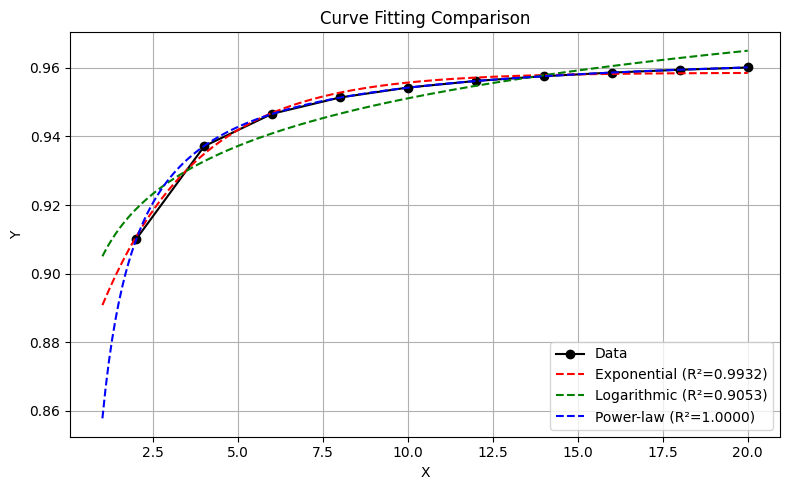

In [13]:
mae_avg_list = []
rmse_avg_list = []
ssim_avg_list = []

for i in [2,4,6,8,10,12,14,16,18,20]:
    mae_avg = data['mae_inference'+str(i)].mean()
    mae_avg_list.append(mae_avg)
    rmse_avg = data['rmse_inference'+str(i)].mean()
    rmse_avg_list.append(rmse_avg)
    ssim_avg = data['ssim_inference'+str(i)].mean()
    ssim_avg_list.append(ssim_avg)
        
y = ssim_avg_list

x = np.array([2,4,6,8,10,12,14,16,18,20])

# Define fitting functions
def log_func(x, a, b):
    return a * np.log(x) + b

def power_func(x, a, b, c):
    return a * x**(-b) + c

def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit the curves
popt_log, _ = curve_fit(log_func, x, y)
popt_pow, _ = curve_fit(power_func, x, y, maxfev=10000)
popt_exp, _ = curve_fit(exp_func, x, y, maxfev=10000)

# Generate predictions
x_fit = np.linspace(1, 20, 200)
y_log = log_func(x_fit, *popt_log)
y_pow = power_func(x_fit, *popt_pow)
y_exp = exp_func(x_fit, *popt_exp)

# Calculate R^2
r2_exp = r2_score(y, exp_func(x, *popt_exp))
r2_log = r2_score(y, log_func(x, *popt_log))
r2_pow = r2_score(y, power_func(x, *popt_pow))

# find the limit of y when x is very large
y_limit_pow = power_func(50, *popt_pow)
print('for power law, the limit of y when x is very large is:', y_limit_pow)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'ko-', label='Data')
plt.plot(x_fit, y_exp, 'r--', label=f'Exponential (R²={r2_exp:.4f})')
plt.plot(x_fit, y_log, 'g--', label=f'Logarithmic (R²={r2_log:.4f})')
plt.plot(x_fit, y_pow, 'b--', label=f'Power-law (R²={r2_pow:.4f})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Curve Fitting Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()